In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
from pandas import DataFrame as dframe
import cvxpy as cv

In [3]:
def Dic(feat_l_tr,feat_r_tr): #入力の配列は2次元配列である必要がある
    feat_tr = np.concatenate([feat_l_tr, feat_r_tr],0)
    return feat_tr

In [4]:
def SRC(feat_tr_dic,feat_l_te,matrix_index):
    answer = np.zeros(feat_l_te.shape[1])
    SRC_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_l_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    SRC_r_Cla = np.zeros((feat_tr_dic.shape[1], feat_l_te.shape[1]))
    for i in range(feat_l_te.shape[1]):
        x = cv.Variable((feat_tr_dic.shape[1],1)) #目的関数の次元
        objective = cv.Minimize(cv.norm(x,1))
        constraints = [feat_l_te[:,i,np.newaxis] == feat_tr_dic@x]
        prob = cv.Problem(objective, constraints)
        result = prob.solve()
        #classVariableから値を取るためには.valueを付ける
        SRC_Cla[:,i] = np.squeeze(x.value)
        #各クラスに関連する表現ベクトルの値を抜き出す
        #lは仕切りの値
        l = 0
        j = 0
        while j < matrix_index.shape[0]-1:
            SRC_l_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]     
            l = l + matrix_index[j]
            j = j + 1
            SRC_r_Cla[l:l+matrix_index[j],i] = SRC_Cla[l:l+matrix_index[j],i]
            l = l + matrix_index[j]
            j = j + 1
    #パラメータを使って擬似的に各クラスのテスト信号の特徴ベクトルを作成
    dout_feat_l_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))
    dout_feat_r_te = np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) 
    for i in range(feat_l_te.shape[1]):
        dout_feat_l_te[:,i] = feat_tr_dic@SRC_l_Cla[:,i]
    for i in range(feat_l_te.shape[1]):
        dout_feat_r_te[:,i] = feat_tr_dic@SRC_r_Cla[:,i]
    #作成した擬似特徴ベクトルとの残差を求める
    R_l =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1])) #残差を格納するための配列
    R_r =  np.zeros((feat_l_te.shape[0], feat_l_te.shape[1]))  
    for i in range(feat_l_te.shape[1]):
        R_l[:,i] = feat_l_te[:,i]-dout_feat_l_te[:,i]
        R_r[:,i] = feat_l_te[:,i]-dout_feat_r_te[:,i]
        if np.linalg.norm(R_l[:,i], ord=2) < np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 1
        elif np.linalg.norm(R_l[:,i], ord=2) > np.linalg.norm(R_r[:,i], ord=2):
            answer[i] = 2
    return answer

In [5]:
def SRC_test(filename1,filename2,filename3,filename4):
    #対象被験者の特徴ベクトルをMATLABから入手
    feat_C1 = np.loadtxt(filename1,delimiter=",")
    feat_C2 = np.loadtxt(filename2,delimiter=",")
    feat_Test_C1 = np.loadtxt(filename3,delimiter=",")
    feat_Test_C2 = np.loadtxt(filename4,delimiter=",")
    #特徴ベクトルを2次元に変換
    #特徴ベクトル g は２M×Tになっている必要がある
    #Tは被験者の試行回数である
    feat_tr_dic = Dic(feat_C1,feat_C2).T
    #feat_tr_dicはすべての特徴ベクトルをつなげたもの
    #まず、分類に用いるテストデータの特徴ベクトルを2次元に変換
    feat_l_te = feat_Test_C1;
    feat_r_te = feat_Test_C2;
    feat_l_te = feat_l_te.T
    feat_r_te = feat_r_te.T
    matrix_index = np.array([feat_C1.shape[0],feat_C2.shape[0]])
    answer1 = SRC(feat_tr_dic,feat_l_te,matrix_index)
    answer2 = SRC(feat_tr_dic,feat_r_te,matrix_index)
    x1 = 0
    x2 = 0
    for i in range(answer1.shape[0]):
        if answer1[i] == 1:
            x1 = x1 + 1
        if answer2[i] == 2:
            x2 = x2 + 1
    temp = ((x1+x2)/(answer1.shape[0]+answer2.shape[0]))*100
    temp1 = ((x1)/(answer1.shape[0]))*100
    temp2 = ((x2)/(answer2.shape[0]))*100
                    
    return temp,temp1,temp2

In [6]:
#train=20,test=20で分類を行った結果
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_left_A01T_30_K0.txt","feat_right_A01T_30_K0.txt","feat_test_left_A01T_30.txt","feat_test_right_A01T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_left_A02T_30_K0.txt","feat_right_A02T_30_K0.txt","feat_test_left_A02T_30.txt","feat_test_right_A02T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_left_A03T_30_K0.txt","feat_right_A03T_30_K0.txt","feat_test_left_A03T_30.txt","feat_test_right_A03T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_left_A04T_30_K0.txt","feat_right_A04T_30_K0.txt","feat_test_left_A04T_30.txt","feat_test_right_A04T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_left_A05T_30_K0.txt","feat_right_A05T_30_K0.txt","feat_test_left_A05T_30.txt","feat_test_right_A05T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_left_A06T_30_K0.txt","feat_right_A06T_30_K0.txt","feat_test_left_A06T_30.txt","feat_test_right_A06T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_left_A07T_30_K0.txt","feat_right_A07T_30_K0.txt","feat_test_left_A07T_30.txt","feat_test_right_A07T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_left_A08T_30_K0.txt","feat_right_A08T_30_K0.txt","feat_test_left_A08T_30.txt","feat_test_right_A08T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
temp,temp1,temp2 = SRC_test("feat_left_A09T_30_K0.txt","feat_right_A09T_30_K0.txt","feat_test_left_A09T_30.txt","feat_test_right_A09T_30.txt")
temp_l = np.array([temp,temp1,temp2])
probability = np.append(probability,temp_l,axis=0)
probability = probability.reshape([9, 3])
print(probability)


[[57.5 30.  85. ]
 [52.5 60.  45. ]
 [72.5 75.  70. ]
 [57.5 25.  90. ]
 [40.  60.  20. ]
 [45.  55.  35. ]
 [40.  70.  10. ]
 [45.  45.  45. ]
 [80.  70.  90. ]]


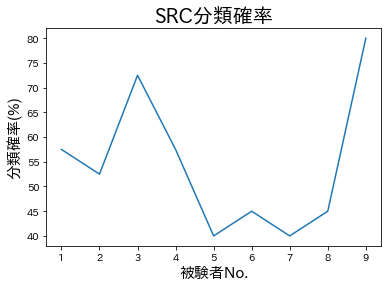

In [7]:
import matplotlib.pyplot as plt
import japanize_matplotlib
x = range(1,10)
y = probability[:,0]
plt.title("SRC分類確率", {"fontsize":20})
plt.xlabel("被験者No.", {"fontsize":15})
plt.ylabel("分類確率(%)", {"fontsize":15})
plt.plot(x,y)
plt.savefig("2a_SRC_probability.pdf")
plt.show()

In [9]:
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_left_emotiv_K0.txt","feat_right_emotiv_K0.txt","feat_test_left_emotiv.txt","feat_test_right_emotiv.txt")
temp_l = np.array([temp,temp1,temp2])
print(temp_l)

[50.  72.5 27.5]


In [10]:
probability = np.array([])
temp,temp1,temp2 = SRC_test("feat_left_emotiv_2_K0.txt","feat_right_emotiv_2_K0.txt","feat_test_left_emotiv_2.txt","feat_test_right_emotiv_2.txt")
temp_l = np.array([temp,temp1,temp2])
print(temp_l)

[45. 80. 10.]
